<a href="https://colab.research.google.com/github/abhigyan2003/keystroke/blob/main/MD_multiple_sessions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo pandas scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math


In [5]:
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split

def split_user_sessions(user_folder, username_label, test_size=0.2):
    csv_files = glob.glob(os.path.join(user_folder, "*.csv"))
    train_dfs, test_dfs = [], []

    # Stratified sampling at the file/session level
    train_files, test_files = train_test_split(csv_files, test_size=test_size, random_state=42)

    def load_files(files, label):
        dfs = []
        for f in files:
            df = pd.read_csv(f, usecols=['x', 'y'])  # Load only needed columns
            df['Username'] = label
            dfs.append(df)
        return dfs

    train_dfs = load_files(train_files, username_label)
    test_dfs = load_files(test_files, username_label)

    return pd.concat(train_dfs, ignore_index=True), pd.concat(test_dfs, ignore_index=True)

# Base directory
base_dir = "/content"
user7_dir = os.path.join(base_dir, "user7")
user9_dir = os.path.join(base_dir, "user9")

# Load and split sessions before merging
user7_train, user7_test = split_user_sessions(user7_dir, "User7")
user9_train, user9_test = split_user_sessions(user9_dir, "User9")

# Combine train and test separately
train_df = pd.concat([user7_train, user9_train], ignore_index=True)
test_df = pd.concat([user7_test, user9_test], ignore_index=True)

print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)

✅ Train shape: (556606, 3)
✅ Test shape: (240546, 3)


In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop NaNs
train_df = train_df.dropna(subset=['x', 'y'])
test_df = test_df.dropna(subset=['x', 'y'])

# Convert types
for df_ in [train_df, test_df]:
    df_['x'] = df_['x'].astype('float32')
    df_['y'] = df_['y'].astype('float32')
    df_['Username'] = df_['Username'].astype('category')

# Fit scaler on training data only
scaler = StandardScaler()
train_df[['x', 'y']] = scaler.fit_transform(train_df[['x', 'y']])
test_df[['x', 'y']] = scaler.transform(test_df[['x', 'y']])

# Fit label encoder only once and apply to both
label_encoder = LabelEncoder()
train_df['UserEncoded'] = label_encoder.fit_transform(train_df['Username'])
test_df['UserEncoded'] = label_encoder.transform(test_df['Username'])

# Done
print("🧠 Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("✅ Train shape:", train_df.shape, "| Test shape:", test_df.shape)


🧠 Label Mapping: {'User7': np.int64(0), 'User9': np.int64(1)}
✅ Train shape: (556606, 4) | Test shape: (240546, 4)


In [9]:
print(train_df.columns.tolist())
print(test_df.columns.tolist())

['x', 'y', 'Username', 'UserEncoded']
['x', 'y', 'Username', 'UserEncoded']


In [11]:
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm import tqdm

def build_sequences(df, seq_len=50, feature_cols=['x', 'y']):
    """
    Builds sequences of shape [N, seq_len, features] with single-user labels.
    """
    X, y = [], []
    label_encoder = LabelEncoder()
    df['UserEncoded'] = label_encoder.fit_transform(df['Username'])

    # Sort by index to keep temporal continuity (or timestamp if available)
    df = df.reset_index(drop=True)

    for i in tqdm(range(len(df) - seq_len)):
        segment = df.iloc[i:i+seq_len]
        users = segment['UserEncoded']

        if len(set(users)) == 1:  # Ensure same user in the entire sequence
            coords = segment[feature_cols].values
            X.append(coords)
            y.append(users.iloc[0])

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    return X, y, label_encoder


In [12]:
SEQ_LEN = 50
features = ['x', 'y']

# Train
X_train, y_train, label_encoder = build_sequences(train_df.copy(), seq_len=SEQ_LEN, feature_cols=features)

# Test (use same label encoder)
test_df['UserEncoded'] = label_encoder.transform(test_df['Username'])
X_test, y_test, _ = build_sequences(test_df.copy(), seq_len=SEQ_LEN, feature_cols=features)

# Display final shapes
print(f"✅ Train X: {X_train.shape}, y: {y_train.shape}")
print(f"✅ Test  X: {X_test.shape}, y: {y_test.shape}")


100%|██████████| 556556/556556 [04:33<00:00, 2035.35it/s]
/tmp/ipython-input-11-3743701512.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)
100%|██████████| 240496/240496 [01:55<00:00, 2085.36it/s]


✅ Train X: torch.Size([556507, 50, 2]), y: torch.Size([556507])
✅ Test  X: torch.Size([240447, 50, 2]), y: torch.Size([240447])


In [13]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cuda


In [15]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# ✅ Convert to numpy for class weight computation
y_train_np = y_train.numpy()

# Compute class weights from training labels only
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Create TensorDatasets
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_test, y_test)  # X_test and y_test from previous block

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# Print info
print(f"✅ Training samples: {len(train_ds)} | Validation samples: {len(val_ds)}")
print("⚖️ Class Weights:", class_weights)


✅ Training samples: 556507 | Validation samples: 240447
⚖️ Class Weights: tensor([1.0629, 0.9441], device='cuda:0')


In [16]:
import torch
import torch.nn as nn
import math

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        H = D // self.d_k
        Q = self.q(x).view(B, T, H, self.d_k).transpose(1, 2)
        K = self.k(x).view(B, T, H, self.d_k).transpose(1, 2)
        V = self.v(x).view(B, T, H, self.d_k).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)
        weights = torch.softmax(scores, dim=-1)
        output = weights @ V

        output = output.transpose(1, 2).contiguous().view(B, T, D)
        return self.out(output)


In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim=128):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x


In [21]:
class MouseDynamicsClassifier(nn.Module):
    def __init__(self, input_dim=2, d_model=64, num_heads=4, num_layers=2, num_classes=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(d_model, num_heads) for _ in range(num_layers)]
        )
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_proj(x)          # [B, T, input_dim] -> [B, T, d_model]
        x = self.pos_enc(x)             # Positional Encoding
        x = self.transformer_blocks(x)  # Transformer layers
        x = x.mean(dim=1)               # Global average pooling
        return self.classifier(x)


model = MouseDynamicsClassifier().to(device)

# Ensure class_weights from your training data is on the same device
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [22]:
from tqdm import tqdm

def train(model, train_dl, val_dl, loss_fn, optimizer, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        loop = tqdm(train_dl, desc=f"🔁 Epoch {epoch+1}/{epochs}", leave=False)
        for xb, yb in loop:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # === Validation Phase ===
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                correct += (preds.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total if total > 0 else 0.0
        print(f"✅ Epoch {epoch+1} | 🔻 Total Loss: {total_loss:.4f} | ✅ Val Accuracy: {acc:.2%}")

# === Run Training ===
train(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=10
)


✅ Epoch 1 | 🔻 Total Loss: 6333.5052 | ✅ Val Accuracy: 79.30%


✅ Epoch 2 | 🔻 Total Loss: 5350.4054 | ✅ Val Accuracy: 83.47%


✅ Epoch 3 | 🔻 Total Loss: 4977.6334 | ✅ Val Accuracy: 83.10%


✅ Epoch 4 | 🔻 Total Loss: 4719.4383 | ✅ Val Accuracy: 82.75%


✅ Epoch 5 | 🔻 Total Loss: 4533.0932 | ✅ Val Accuracy: 82.22%


✅ Epoch 6 | 🔻 Total Loss: 4373.9106 | ✅ Val Accuracy: 85.62%


✅ Epoch 7 | 🔻 Total Loss: 4239.2423 | ✅ Val Accuracy: 83.69%


✅ Epoch 8 | 🔻 Total Loss: 4162.5796 | ✅ Val Accuracy: 85.03%


✅ Epoch 9 | 🔻 Total Loss: 4090.6555 | ✅ Val Accuracy: 84.43%


✅ Epoch 10 | 🔻 Total Loss: 4003.7869 | ✅ Val Accuracy: 85.79%


📊 Classification Report:

              precision    recall  f1-score   support

       User7       0.90      0.84      0.87    131896
       User9       0.82      0.88      0.85    108551

    accuracy                           0.86    240447
   macro avg       0.86      0.86      0.86    240447
weighted avg       0.86      0.86      0.86    240447



/tmp/ipython-input-23-2884539710.py:31: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


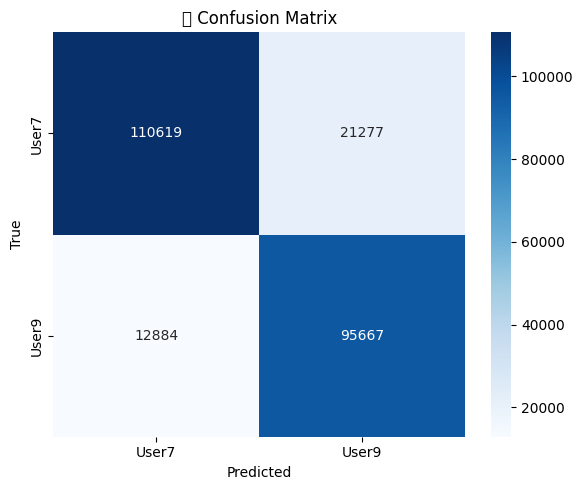

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Evaluation ===
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.argmax(dim=1).cpu().tolist())

# === Classification Report ===
print("📊 Classification Report:\n")
print(classification_report(
    y_true, y_pred, target_names=label_encoder.classes_)
)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🧠 Confusion Matrix")
plt.tight_layout()
plt.show()


/tmp/ipython-input-26-4159146478.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


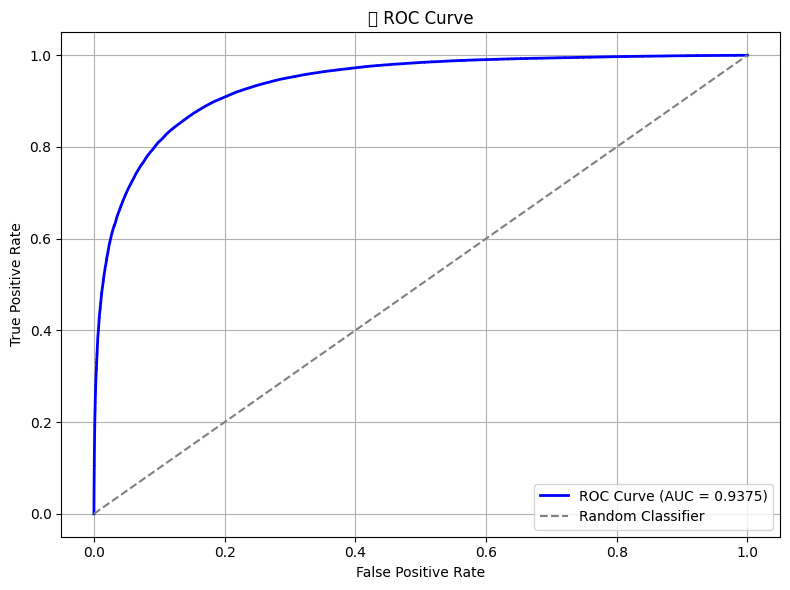

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# === Probabilities for class "User9" (label 1 if using LabelEncoder)
y_probs = []
model.eval()

with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(device)
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # Probability of class 1
        y_probs.extend(probs.cpu().tolist())

# Ensure `y_true` is ready (already collected during evaluation earlier)
# Compute AUC
auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

# === Plot ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
